---
syncID: 75f8885948494c0dbe6084099c61dd1e
title: "Unsupervised Spectral Classification in Python: KMeans & PCA"
description: "Learn to classify spectral data using KMeans and Principal Components Analysis (PCA)."
dateCreated: 2018-07-10 
authors: Bridget Hass
contributors: Donal O'Leary
estimatedTime: 1 hour
packagesLibraries: gdal, h5py, neonutilities
topics: hyperspectral-remote-sensing, HDF5, remote-sensing, classification
languagesTool: python
dataProduct: NEON.DP1.30006, NEON.DP3.30006
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Hyperspectral/classification/kmeans-pca/classification_kmeans_pca.ipynb
tutorialSeries: 
urlTitle: classification-kmeans-pca
---

In this tutorial, we will use the `Spectral Python (SPy)` package to run a KMeans unsupervised classification algorithm and then we will run Principal Component Analysis to reduce data dimensionality.

<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Run kmeans unsupervised classification on AOP hyperspectral data
* Reduce data dimensionality using Principal Component Analysis (PCA)

### Install Python Packages

* **gdal**
* **h5py**
* **scikit-image**
* **spectral**
* **requests**

### For visualization (optional)
* `pip install wxPython`
* `pip install PyOpenGL PyOpenGL_accelerate`

### Download Data

This tutorial uses am AOP <a href="https://data.neonscience.org/data-products/DP3.30006.002" target="blank">Hyperspectral Surface Bidirectional Reflectance</a> tile (1 km x 1 km) from the NEON <a href="https://www.neonscience.org/field-sites/serc" target="blank">Smithsonian Environmental Research Center (SERC)</a> site.

The data required for this lesson will be downloaded in the beginning of the tutorial using the Python `neonutilities` package.

</div>

In this tutorial, we will use the `Spectral Python (SPy)` package to run KMeans unsupervised classification algorithm as well as Principal Component Analysis (PCA).

To learn more about the Spectral Python packages read: 

* <a href="http://www.spectralpython.net/user_guide.html" target="blank">Spectral Python User Guide</a>.
* <a href="http://www.spectralpython.net/algorithms.html#unsupervised-classification" target="_blank">Spectral Python Unsupervised Classification</a>.


## KMeans Clustering


**KMeans** is an iterative clustering algorithm used to classify unsupervised data (eg. data without a training set) into a specified number of groups. The algorithm begins with an initial set of randomly determined cluster centers. Each pixel in the image is then assigned to the nearest cluster center (using distance in N-space as the distance metric) and each cluster center is then re-computed as the centroid of all pixels assigned to the cluster. This process repeats until a desired stopping criterion is reached (e.g. max number of iterations). 

Read more on KMeans clustering from <a href="http://www.spectralpython.net/algorithms.html#k-means-clustering" target="_blank">Spectral Python</a>. 

To visualize how the algorithm works, it's easier look at a 2D data set. In the example below, watch how the cluster centers shift with progressive iterations, 

 <figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/KMeans2D.gif">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/KMeans2D.gif"></a>
	<figcaption> KMeans clustering demonstration Source: <a href="https://sandipanweb.wordpress.com/2017/03/19/hard-soft-clustering-with-k-means-weighted-k-means-and-gmm-em/" target="_blank">Sandipan Deyn</a>
	</figcaption>
</figure>


## Principal Component Analysis (PCA) - Dimensionality Reduction

Many of the bands within hyperspectral images are often strongly correlated. The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands).

Read more about PCA with 
<a href="http://www.spectralpython.net/algorithms.html#principal-components" target="_blank">Spectral Python</a>.


## Set up

To run this notebook, the following Python packages need to be installed. You can install required packages from the command line (prior to opening your notebook), e.g. `pip install gdal h5py neonutilities scikit-learn spectral requests`.

or if already in a Jupyter Notebook, run `!pip install` with the same packages.
 
Packages:
- gdal
- h5py
- neonutilities
- requests
- spectral
- scikit-learn

**Optional:**

In order to make use of the interactive graphics capabilities of `spectralpython`, such as `N-Dimensional Feature Display`, you will need some additional packages. These are not required to complete this lesson.

For more information, refer to <a href="http://www.spectralpython.net/graphics.html" target="_blank">Spectral Python Graphics</a>.

First, import the required packages and set display preferences:

In [1]:
import h5py
import matplotlib
import neonutilities as nu
import numpy as np
import os
import requests
from spectral import *
from time import time

In [2]:
home_dir = os.path.expanduser("~")
data_dir = os.path.join(home_dir,'data')

For this example, we will download a bidirectional surface reflectance data cube at the SERC site, collected in 2022.

In [3]:
nu.by_tile_aop(dpid='DP3.30006.002',
               site='SERC',
               year='2022',
               easting=368005,
               northing=4306005,
               include_provisional=True,
               #token=your_token_here
               savepath=os.path.join(data_dir)) # save to the home directory under a 'data' subfolder

Provisional data are included. To exclude provisional data, use input parameter include_provisional=False.


Continuing will download 2 files totaling approximately 692.0 MB. Do you want to proceed? (y/n)  n


Download halted


Let's see what data were downloaded.

In [4]:
# iterating over directory and subdirectory to get desired result
for root, dirs, files in os.walk(data_dir):
    for name in files:
        if name.endswith('.h5'):
            print(os.path.join(root, name))  # printing file name

C:\Users\bhass\data\DP3.30006.002\neon-aop-provisional-products\2022\FullSite\D02\2022_SERC_6\L3\Spectrometer\Reflectance\NEON_D02_SERC_DP3_368000_4306000_bidirectional_reflectance.h5


In [5]:
h5_tile = r'C:\Users\bhass\data\DP3.30006.002\neon-aop-provisional-products\2022\FullSite\D02\2022_SERC_6\L3\Spectrometer\Reflectance\NEON_D02_SERC_DP3_368000_4306000_bidirectional_reflectance.h5'

In [6]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

In [7]:
module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_hyperspectral.py"
download_url(module_url,'../python_modules')
# os.listdir('../python_modules') #optionally show the contents of this directory to confirm the file downloaded

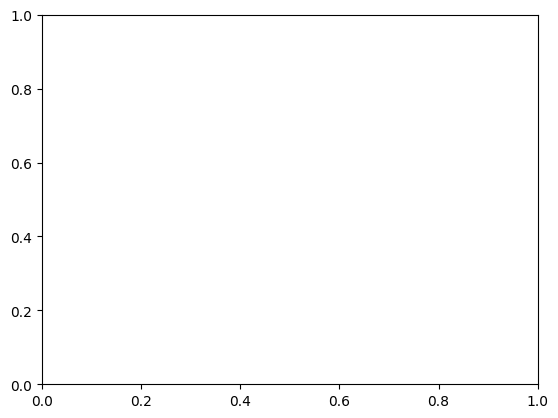

In [8]:
sys.path.insert(0, '../python_modules')
# import the neon_aop_hyperspectral module, the semicolon supresses an empty plot from displaying
import neon_aop_hyperspectral as neon_hs;

In [9]:
# read in the reflectance data using the aop_h5refl2array function, this may also take a bit of time
start_time = time()
refl, refl_metadata, wavelengths = neon_hs.aop_h5refl2array(h5_tile,'Reflectance')
print("--- It took %s seconds to read in the data ---" % round((time() - start_time),0))

Reading in  C:\Users\bhass\data\DP3.30006.002\neon-aop-provisional-products\2022\FullSite\D02\2022_SERC_6\L3\Spectrometer\Reflectance\NEON_D02_SERC_DP3_368000_4306000_bidirectional_reflectance.h5
--- It took 27.0 seconds to read in the data ---


The next few cells show how you can look at the contents, values, and dimensions of the `refl_metadata`, `wavelengths`, and `refl` variables, respectively.

In [10]:
refl_metadata

{'shape': (1000, 1000, 426),
 'no_data_value': -9999.0,
 'scale_factor': 10000.0,
 'bad_band_window1': array([1340, 1445]),
 'bad_band_window2': array([1790, 1955]),
 'projection': b'+proj=UTM +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
 'EPSG': 32618,
 'res': {'pixelWidth': 1.0, 'pixelHeight': 1.0},
 'extent': (368000.0, 369000.0, 4306000.0, 4307000.0),
 'ext_dict': {'xMin': 368000.0,
  'xMax': 369000.0,
  'yMin': 4306000.0,
  'yMax': 4307000.0},
 'source': 'C:\\Users\\bhass\\data\\DP3.30006.002\\neon-aop-provisional-products\\2022\\FullSite\\D02\\2022_SERC_6\\L3\\Spectrometer\\Reflectance\\NEON_D02_SERC_DP3_368000_4306000_bidirectional_reflectance.h5'}

In [11]:
print('First and last 5 center wavelengths, in nm:')
print(wavelengths[:5])
print(wavelengths[-5:])

First and last 5 center wavelengths, in nm:
[383.884003 388.891693 393.899506 398.907196 403.915009]
[2492.149414 2497.157227 2502.165039 2507.172607 2512.18042 ]


In [12]:
refl.shape

(1000, 1000, 426)

Next let's define a function to clean and subset the data. 

In [13]:
def clean_neon_refl_data(data, metadata, wavelengths, subset_factor=1):
    """Clean h5 reflectance data and metadata
    1. set data ignore value (-9999) to NaN
    2. apply reflectance scale factor (10000)
    3. remove bad bands (water vapor band windows + last 10 bands): 
        Band_Window_1_Nanometers = 1340, 1445
        Band_Window_2_Nanometers = 1790, 1955
    4. if subset_factor, subset by that factor
    """
    
    # use copy so original data and metadata doesn't change
    data_clean = data.copy().astype(float)
    metadata_clean = metadata.copy()
    
    #set data ignore value (-9999) to NaN:
    if metadata['no_data_value'] in data:
        nodata_ind = np.where(data_clean==metadata['no_data_value'])
        data_clean[nodata_ind]=np.nan 
    
    #apply reflectance scale factor (divide by 10000)
    data_clean = data_clean/metadata['scale_factor']
    
    #remove bad bands 
    #1. define indices corresponding to min/max center wavelength for each bad band window:
    bb1_ind0 = np.max(np.where(np.asarray(wavelengths<float(metadata['bad_band_window1'][0]))))
    bb1_ind1 = np.min(np.where(np.asarray(wavelengths>float(metadata['bad_band_window1'][1]))))

    bb2_ind0 = np.max(np.where(np.asarray(wavelengths<float(metadata['bad_band_window2'][0]))))
    bb2_ind1 = np.min(np.where(np.asarray(wavelengths>float(metadata['bad_band_window2'][1]))))
    bb3_ind0 = len(wavelengths)-15
    
    #define valid band ranges from indices:
    vb1 = list(range(10,bb1_ind0)); 
    vb2 = list(range(bb1_ind1,bb2_ind0))
    vb3 = list(range(bb2_ind1,bb3_ind0))
    # combine them to get a list of the valid bands
    vbs = vb1 + vb2 + vb3
    # subset by subset_factor (if subset_factor = 1 this will return the original valid_bands list)
    valid_bands_subset = vbs[::subset_factor]

    # subset the reflectance data by the valid_bands_subset
    data_clean = data_clean[:,:,valid_bands_subset]

    # subset the wavelengths by the same valid_bands_subset
    wavelengths_clean =[wavelengths[i] for i in valid_bands_subset]
    
    return data_clean, wavelengths_clean

Now use this function to clean and subset the data, using a subset factor of 2 to start.

In [14]:
# clean the data - remove the band bands and subset
start_time = time()
refl_clean, wavelengths_clean = clean_neon_refl_data(refl, refl_metadata, wavelengths, subset_factor=2)
print("--- It took %s seconds to clean and subset the reflectance data ---" % round((time() - start_time),0))

--- It took 12.0 seconds to clean and subset the reflectance data ---


In [15]:
# Look at the dimensions of the data after cleaning:
print('Cleaned Data Dimensions:',refl_clean.shape)
print('Cleaned Wavelengths:',len(wavelengths_clean))

Cleaned Data Dimensions: (1000, 1000, 173)
Cleaned Wavelengths: 173


In [16]:
start_time = time()
# run kmeans with 5 clusters and 50 iterations
(m,c) = kmeans(refl_clean, 5, 50) 
print("--- It took %s minutes to run kmeans on the reflectance data ---" % round((time() - start_time)/60,1))

spectral:INFO: k-means iteration 1 - 373101 pixels reassigned.
k-means iteration 1 - 373101 pixels reassigned.
spectral:INFO: k-means iteration 2 - 135441 pixels reassigned.
k-means iteration 2 - 135441 pixels reassigned.
spectral:INFO: k-means iteration 3 - 54918 pixels reassigned.
k-means iteration 3 - 54918 pixels reassigned.
spectral:INFO: k-means iteration 4 - 37397 pixels reassigned.
k-means iteration 4 - 37397 pixels reassigned.
spectral:INFO: k-means iteration 5 - 25964 pixels reassigned.
k-means iteration 5 - 25964 pixels reassigned.
spectral:INFO: k-means iteration 6 - 22079 pixels reassigned.
k-means iteration 6 - 22079 pixels reassigned.
spectral:INFO: k-means iteration 7 - 20998 pixels reassigned.
k-means iteration 7 - 20998 pixels reassigned.
spectral:INFO: k-means iteration 8 - 21289 pixels reassigned.
k-means iteration 8 - 21289 pixels reassigned.
spectral:INFO: k-means iteration 9 - 23434 pixels reassigned.
k-means iteration 9 - 23434 pixels reassigned.
spectral:INFO: 

--- It took 3.7 minutes to run kmeans on the reflectance data ---


Note that the algorithm still had on the order of 10000 clusters reassigning, when the 50 iterations were reached. You may extend the # of iterations.

**Data Tip**: You can iterrupt the algorithm with a keyboard interrupt (CTRL-C) if you notice that the number of reassigned pixels drops off. Kmeans catches the `KeyboardInterrupt` exception and returns the clusters generated at the end of the previous iteration. If you are running the algorithm interactively, this feature allows you to set the max number of iterations to an arbitrarily high number and then stop the algorithm when the clusters have converged to an acceptable level. If you happen to set the max number of iterations too small (many pixels are still migrating at the end of the final iteration), you cancall kmeans again to resume processing by passing the cluster centers generated by the previous call as the optional `start_clusters` argument to the function.

Let's try that now:

In [17]:
start_time = time()
# run kmeans with 5 clusters and 50 iterations
(m, c) = kmeans(refl_clean, 5, 50, start_clusters=c) 
print("--- It took %s minutes to run kmeans on the reflectance data ---" % round((time() - start_time)/60,1))

spectral:INFO: k-means iteration 1 - 787247 pixels reassigned.
k-means iteration 1 - 787247 pixels reassigned.
spectral:INFO: k-means iteration 2 - 7684 pixels reassigned.
k-means iteration 2 - 7684 pixels reassigned.
spectral:INFO: k-means iteration 3 - 6552 pixels reassigned.
k-means iteration 3 - 6552 pixels reassigned.
spectral:INFO: k-means iteration 4 - 5462 pixels reassigned.
k-means iteration 4 - 5462 pixels reassigned.
spectral:INFO: k-means iteration 5 - 4681 pixels reassigned.
k-means iteration 5 - 4681 pixels reassigned.
spectral:INFO: k-means iteration 6 - 4011 pixels reassigned.
k-means iteration 6 - 4011 pixels reassigned.
spectral:INFO: k-means iteration 7 - 3325 pixels reassigned.
k-means iteration 7 - 3325 pixels reassigned.
spectral:INFO: k-means iteration 8 - 2843 pixels reassigned.
k-means iteration 8 - 2843 pixels reassigned.
spectral:INFO: k-means iteration 9 - 2411 pixels reassigned.
k-means iteration 9 - 2411 pixels reassigned.
spectral:INFO: k-means iteration 

--- It took 3.6 minutes to run kmeans on the reflectance data ---


Passing the initial clusters in sped up the convergence considerably, the second time around.

Let's take a look at the new cluster centers `c`. In this case, these represent spectral signatures of the five clusters (classes) that the data were grouped into. First we can take a look at the shape:

In [18]:
print(c.shape)

(5, 173)


`c` contains 5 groups of spectral curves with 173 bands (the # of bands we've kept after subsetting and removing the water vapor windows, first 10 noisy bands and last 15 noisy bands). We can plot these spectral classes as follows:

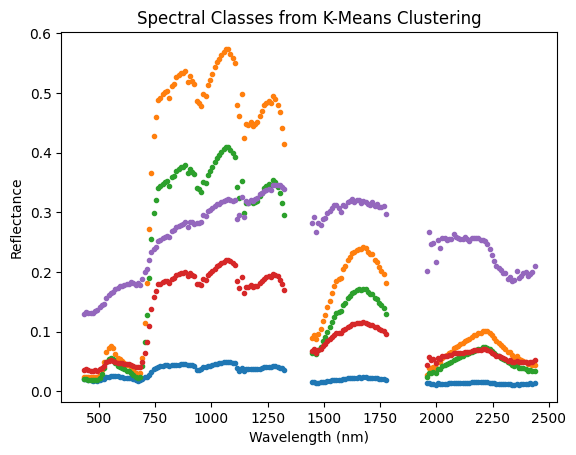

In [19]:
import pylab
pylab.figure()
for i in range(c.shape[0]):
    pylab.plot(wavelengths_clean, c[i],'.')
pylab.show
pylab.title('Spectral Classes from K-Means Clustering')
pylab.xlabel('Wavelength (nm)')
pylab.ylabel('Reflectance');

Next, we can look at the classes in map view, as well as a true color image.

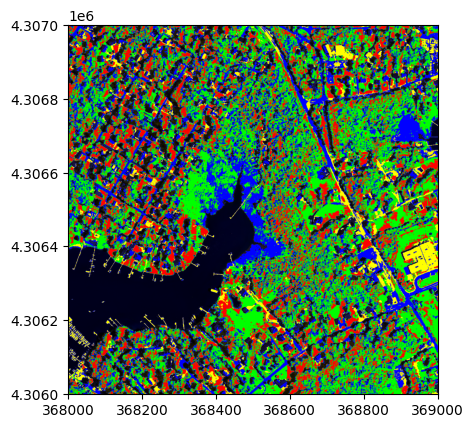

In [20]:
view = imshow(refl_clean, bands=(58,34,19),stretch=0.01, classes=m, extent=refl_metadata['extent'])
view.set_display_mode('overlay')
view.class_alpha = 1 #set transparency
view.show_data;

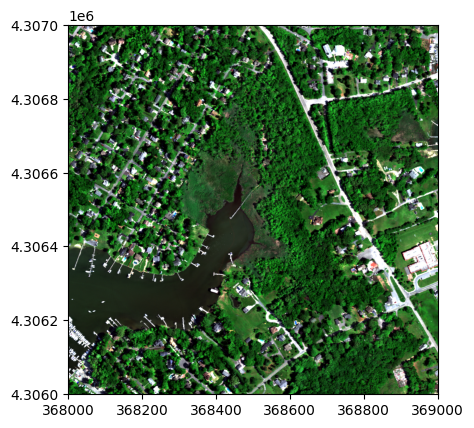

In [21]:
view = imshow(refl_clean, bands=(24,12,4), stretch=0.03, extent=refl_metadata['extent'])
view.show_data;

## Challenge Questions: K-Means

1. What do you think the spectral classes in the figure you just created represent? 
2. Try using a different number of clusters in the `kmeans` algorithm (e.g., 3 or 10) to see what spectral classes and classifications result.
3. Try using  different (higher) subset_factor in the `clean_neon_refl_data` function, like 3 or 5. Does this factor change the final classes that are created in the kmeans algorithm? By how much can you subset the data by and still achieve similar classification results?

## Principal Component Analysis (PCA)

This next section follows the <a href="https://www.spectralpython.net/algorithms.html#dimensionality-reduction" target="blank">Spectral Python Dimensionality Reduction</a> section closely.

Many of the bands within hyperspectral images are often strongly correlated. The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands) .

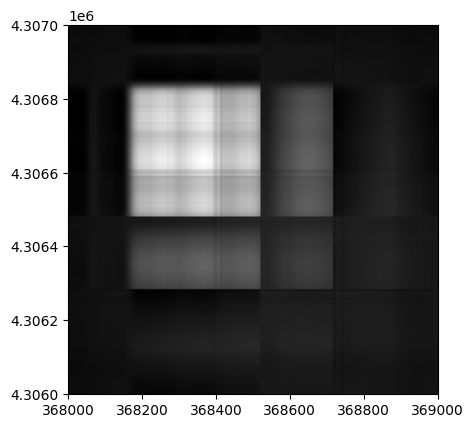

In [31]:
pc = principal_components(refl_clean)
pc_view = imshow(pc.cov, extent=refl_metadata['extent'])
xdata = pc.transform(refl_clean)

In the covariance matrix display, lighter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero. 

To reduce dimensionality using principal components, we can sort the eigenvalues in descending order and then retain enough eigenvalues (anD corresponding eigenvectors) to capture a desired fraction of the total image variance. We then reduce the dimensionality of the image pixels by projecting them onto the remaining eigenvectors. We will choose to retain a minimum of 99.9% of the total image variance.

You can see that even though we've only retained a subset of the bands, a lot of the details about the scene are still visible.

If you had training data, you could use a Gaussian maximum likelihood classifier (GMLC) for the reduced principal components to train and classify against the training data.

## Challenge Questions: PCA

1. Run the k-means classification after running PCA and see if you get similar results. Does / how does reducing the data dimensionality affect the classification results?

# of eigenvalues: 9
(1000, 1000, 9)


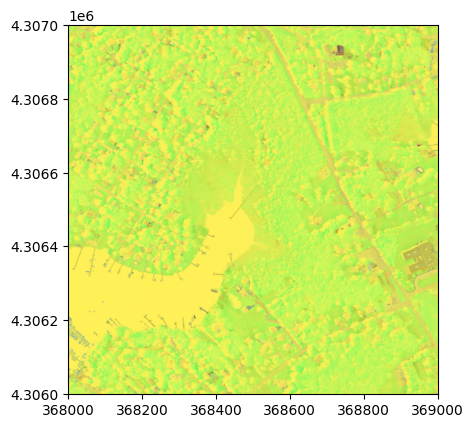

In [29]:
pc_999 = pc.reduce(fraction=0.999)

# How many eigenvalues are left?
print('# of eigenvalues:',len(pc_999.eigenvalues))

img_pc = pc_999.transform(refl_clean)
print(img_pc.shape)

v = imshow(img_pc[:,:,:3], stretch_all=True, extent=refl_metadata['extent']);